In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm
from scipy.spatial import cKDTree
import scipy.stats as stats
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

In [2]:
africa_iso_countries_SSA = {
    "AGO": ["Angola"],
    "BEN": ["Benin"],
    "BWA": ["Botswana"],
    "BFA": ["Burkina Faso"],
    "BDI": ["Burundi"],
    "CMR": ["Cameroon"],
    "CPV": ["Cabo Verde"],
    "CAF": ["Central African Republic"],
    "TCD": ["Chad"],
    "CIV": ["Côte d'Ivoire", "CÃ´te d'Ivoire"],
    "COM": ["Comoros"],
    "COG": ["Republic of Congo", "Congo"],
    "COD": ["Democratic Republic of the Congo"],
    "DJI": ["Djibouti"],
    "GNQ": ["Equatorial Guinea"],
    "ERI": ["Eritrea"],
    "SWZ": ["Eswatini", "Swaziland"],
    "ETH": ["Ethiopia"],
    "GAB": ["Gabon"],
    "GMB": ["Gambia"],
    "GHA": ["Ghana"],
    "GIN": ["Guinea"],
    "GNB": ["Guinea-Bissau"],
    "KEN": ["Kenya"],
    "LSO": ["Lesotho"],
    "LBR": ["Liberia"],
    "MDG": ["Madagascar"],
    "MWI": ["Malawi"],
    "MLI": ["Mali"],
    "MRT": ["Mauritania"],
    "MUS": ["Mauritius"],
    "MOZ": ["Mozambique"],
    "NAM": ["Namibia"],
    "NER": ["Niger"],
    "NGA": ["Nigeria"],
    "RWA": ["Rwanda"],
    "STP": ["São Tomé and Príncipe", "Sao Tome and Principe"],
    "SEN": ["Senegal"],
    "SYC": ["Seychelles"],
    "SLE": ["Sierra Leone"],
    "SOM": ["Somalia"],
    "ZAF": ["South Africa"],
    "SSD": ["South Sudan"],
    "SDN": ["Sudan"],
    "TZA": ["Tanzania"],
    "TGO": ["Togo"],
    "UGA": ["Uganda"],
    "ZMB": ["Zambia"],
    "ZWE": ["Zimbabwe"]
}

country_to_iso = {}
for iso, names in africa_iso_countries_SSA.items():
    for name in names:
        country_to_iso[name] = iso


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterstats import zonal_stats
import pandas as pd
import numpy as np

# Load
cpis = gpd.read_file(resolve_path(config['SSA_Combined_CPIS_All_shp_path']))
dams = gpd.read_file(resolve_path(config['AridAfrica_Barriers_shp_path']))
dams.rename(columns={'COUNTRY': 'Country'}, inplace=True)
ca = gpd.read_file(resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path']))
arid_ssa = gpd.read_file(resolve_path(config['SSA_Arid_by_Country_shp_path']))
irrig_raster_path = resolve_path(config['Africa_AEI_2000_asc_path'])

# Standardize CRS and ISO/Country column names
projected_crs = "EPSG:3857"
cpis = cpis.to_crs(projected_crs)
dams = dams.to_crs(projected_crs)


dams['ISO'] = dams['Country'].map(country_to_iso)
dams = dams[dams['ISO'].isin(africa_iso_countries_SSA)]
dams = dams[(dams['DAM_HGT_M'] > 15) & (dams['MAIN_USE'] == 'Irrigation')]

print("Data loaded and CRS matched")

# === Compute total CPIS area per country ===
cpis['area_m2'] = cpis.geometry.area
cpis.rename(columns={'ISO3': 'ISO'}, inplace=True)
national_cpis = cpis.groupby('ISO')['area_m2'].sum().rename("CPIS_country_area")
national_cpis = national_cpis[national_cpis.index.isin(africa_iso_countries_SSA)]

print("\nNational CPIS area (first 5 rows):")
print(national_cpis.head())

# === Compute total irrigated area per country from raster ===
with rasterio.open(irrig_raster_path) as src:
    irrig_meta = src.meta.copy()
    irrig_data = src.read(1)  # Read the irrigation data
    irrig_transform = src.transform
    irrig_crs = "EPSG:4326"  # Use the CRS from the raster file


# Ensure the 'ISO' column exists or use an alternative
if 'ISO' not in arid_ssa.columns:
    raise KeyError("The 'ISO' column is missing from the country boundaries shapefile. Please check the data.")

# Update metadata for the new raster
irrig_meta.update(dtype='int32', count=1)

# Perform zonal statistics to calculate total irrigated area per country
arid_ssa = arid_ssa.to_crs(irrig_crs)
stats = zonal_stats(arid_ssa, irrig_raster_path, stats=["sum"], geojson_out=True)

# Create a dictionary mapping countries to their irrigated areas
irrig_by_country = {
    feature['properties']['ISO']: feature['properties']['sum'] for feature in stats
}

# Convert to a pandas Series for easier mapping
national_irrig = pd.Series(irrig_by_country, name="Irr_country_area")
national_irrig = national_irrig[national_irrig.index.isin(africa_iso_countries_SSA)]
national_irrig *= 10_000  # convert from hectares to m²


print("\nNational irrigated area from raster (first 5 rows):")
print(national_irrig.head())

# === CPIS within each command area ===
ca_proj = ca.to_crs(projected_crs)
cpis_ca = gpd.overlay(cpis, ca_proj, how='intersection')
cpis_ca['area_m2'] = cpis_ca.geometry.area
cpis_by_dam = cpis_ca.groupby('GDW_ID')['area_m2'].sum().rename("CPIS_in_CA")

print("\nCPIS area within command areas (first 5 rows):")
print(cpis_by_dam.head())

# === Irrigated area within each command area ===
ca_zonal = ca.to_crs(irrig_crs)
ca_stats = zonal_stats(ca_zonal, irrig_raster_path, stats=["sum"], geojson_out=False)
ca['Irr_in_CA'] = [s["sum"] for s in ca_stats]
ca['Irr_in_CA'] = ca['Irr_in_CA'] * 10_000  # convert from hectares to m²
print("\nIrrigated area within each command area (first 5 rows):")
print(ca[['Irr_in_CA']].head())


# === Merge all sources together ===
print("Columns in ca:", ca.columns)
print("Columns in dams:", dams.columns)

ca_merge = ca.merge(dams[['GDW_ID', 'Country', 'ISO']], on='GDW_ID', how='left')
print("Columns in ca_merge:", ca_merge.columns)

ca_indexed = ca_merge.set_index('GDW_ID')
print("Columns in ca_indexed:", ca_indexed.columns)
ca_indexed = ca_indexed.join(cpis_by_dam.rename("CPIS_in_CA")).fillna(0)

# Map national CPIS and irrigated area to ca_indexed
ca_indexed['CPIS_country_area'] = ca_indexed['ISO'].map(national_cpis)
ca_indexed['Irr_country_area'] = ca_indexed['ISO'].map(national_irrig)

# Avoid division by zero
ca_indexed = ca_indexed[ca_indexed['Irr_country_area'] > 0]

print("\nMerged dataset (first 5 rows):")
print(ca_indexed[['Country', 'CPIS_in_CA', 'Irr_in_CA', 'CPIS_country_area', 'Irr_country_area']].head())

# === Compute expected CPIS ===
ca_indexed['Expected_CPIS'] = ca_indexed['Irr_in_CA'] * (
    ca_indexed['CPIS_country_area'] / ca_indexed['Irr_country_area']
)

print("\nExpected CPIS under national proportion model (first 5 rows):")
print(ca_indexed[['Expected_CPIS']].head())

# === Compute targeting ratio ===
total_actual = ca_indexed['CPIS_in_CA'].sum()
total_expected = ca_indexed['Expected_CPIS'].sum()
targeting_ratio = total_actual / total_expected if total_expected > 0 else np.nan

print("\nFinal Targeting Ratio:")
print(f"    Total Actual CPIS in CA: {total_actual:,.0f} m²")
print(f"    Total Expected CPIS:     {total_expected:,.0f} m²")
print(f"    Targeting Ratio:         {targeting_ratio:.3f}")

Data loaded and CRS matched

National CPIS area (first 5 rows):
ISO
AGO    1.815843e+07
BFA    2.636226e+07
BWA    2.762354e+07
GHA    1.942533e+06
GMB    3.184753e+06
Name: CPIS_country_area, dtype: float64

National irrigated area from raster (first 5 rows):
SDN    1.855828e+10
MRT    4.501200e+08
ERI    2.159000e+08
SEN    9.863646e+08
GMB    2.149000e+07
Name: Irr_country_area, dtype: float64

CPIS area within command areas (first 5 rows):
GDW_ID
353     3.939440e+06
404     3.032620e+07
407     1.642970e+08
408     4.583666e+08
2012    2.526966e+06
Name: CPIS_in_CA, dtype: float64

Irrigated area within each command area (first 5 rows):
      Irr_in_CA
0  9.715296e+05
1  7.923903e+07
2  3.470741e+06
3  1.874362e+07
4           NaN
Columns in ca: Index(['area', 'ResArea', 'dH', 'MaxDist', 'Geom_type', 'type', 'GDW_ID',
       'validCA', 'ResElev', 'RAreaPct', 'backupCap', 'Yield', 'ResCapBath',
       'RBackupCap', 'geometry', 'Irr_in_CA'],
      dtype='object')
Columns in dams: In

In [4]:
import random

n_bootstrap = 10000  # number of bootstrap samples
bootstrap_ratios = []

dam_ids = ca_indexed.index.unique()  # unique dam GDW_IDs

for _ in range(n_bootstrap):
    # Resample dams with replacement
    resampled_dams = np.random.choice(dam_ids, size=len(dam_ids), replace=True)
    
    resampled = ca_indexed.loc[resampled_dams]

    # Compute actual and expected CPIS for this resample
    actual = resampled['CPIS_in_CA'].sum()
    expected = resampled['Expected_CPIS'].sum()
    
    ratio = actual / expected if expected > 0 else np.nan
    bootstrap_ratios.append(ratio)

# Convert to numpy array
bootstrap_ratios = np.array(bootstrap_ratios)
bootstrap_ratios = bootstrap_ratios[~np.isnan(bootstrap_ratios)]  # Drop NaNs

# Compute statistics
mean_ratio = np.mean(bootstrap_ratios)
median_ratio = np.median(bootstrap_ratios)
lower_ci, upper_ci = np.percentile(bootstrap_ratios, [2.5, 97.5])

print("\n=== Bootstrap Targeting Ratio Results ===")
print(f"Mean Targeting Ratio: {mean_ratio:.3f}")
print(f"Median Targeting Ratio: {median_ratio:.3f}")
print(f"95% CI: ({lower_ci:.3f}, {upper_ci:.3f})")



=== Bootstrap Targeting Ratio Results ===
Mean Targeting Ratio: 1.491
Median Targeting Ratio: 1.486
95% CI: (0.427, 2.601)


Original number of dams: 2764
Filtered dams count: 171
Data loaded and CRS matched

Countries with nonzero national CPIS area:
ISO
AGO    1.815843e+07
BFA    2.636226e+07
BWA    2.762354e+07
GHA    1.942533e+06
GMB    3.184753e+06
KEN    3.152694e+07
LSO    2.060457e+06
MDG    2.847585e+07
MLI    1.657522e+07
MOZ    3.988731e+07
MRT    4.715213e+06
MWI    3.070110e+07
NAM    9.162376e+07
NGA    6.024479e+05
SEN    3.202247e+07
SWZ    9.739403e+07
TCD    3.979626e+07
ZAF    7.950810e+09
ZMB    6.276215e+08
ZWE    6.459938e+08
Name: CPIS_country_area, dtype: float64
Total countries with CPIS > 0: 20


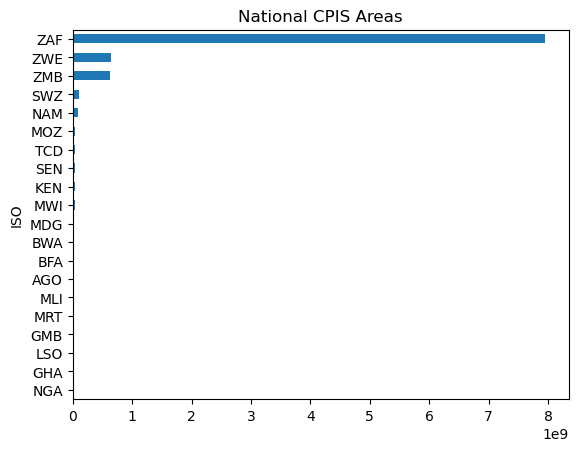


Countries with nonzero national irrigated area:
SDN    1.855828e+10
MRT    4.501200e+08
ERI    2.159000e+08
SEN    9.863646e+08
GMB    2.149000e+07
ETH    1.517740e+09
GIN    1.043450e+07
MLI    2.355313e+09
SOM    2.000000e+09
BFA    2.321633e+08
NGA    2.109165e+09
BEN    1.862996e+07
TGO    1.676504e+07
GHA    3.460041e+07
CIV    3.998021e+06
SSD    7.172281e+07
CMR    1.787900e+08
TCD    2.600000e+08
KEN    2.144214e+08
BDI    2.487498e+06
AGO    6.151482e+08
ZMB    1.015292e+09
NER    7.334800e+08
MWI    1.005899e+08
MOZ    5.047350e+08
MDG    1.408469e+09
ZWE    1.594627e+09
ZAF    1.377558e+10
NAM    7.573000e+07
SWZ    4.332974e+08
LSO    2.555794e+07
BWA    1.439000e+07
Name: Irr_country_area, dtype: float64
Total countries with irrigated area > 0: 32


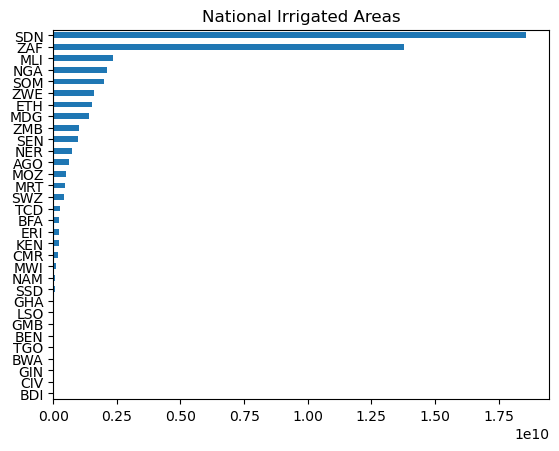


Total dams with CPIS detected in CA:
Number of dams with CPIS > 0: 50 out of 50

Total dams with irrigated area in CA:
Number of dams with irrigation > 0: 50 out of 171
Columns in ca: Index(['area', 'ResArea', 'dH', 'MaxDist', 'Geom_type', 'type', 'GDW_ID',
       'validCA', 'ResElev', 'RAreaPct', 'backupCap', 'Yield', 'ResCapBath',
       'RBackupCap', 'geometry', 'Irr_in_CA'],
      dtype='object')
Columns in dams: Index(['USE_OTHR', 'DOR_PC', 'DATA_INFO', 'HYLAK_ID', 'LAKE_CTRL', 'Country',
       'REM_YEAR', 'POWER_MW', 'SUB_BASIN', 'DIS_AVG_LS', 'TIMELINE',
       'YEAR_DAM', 'LAT_DAM', 'INSTREAM', 'AREA_REP', 'MAIN_BASIN', 'ORIG_SRC',
       'ADMIN_UNIT', 'DAM_TYPE', 'LONG_RIV', 'AREA_SKM', 'CAP_MCM', 'LAT_RIV',
       'CAP_REP', 'ALT_RIVER', 'USE_RECR', 'USE_FISH', 'USE_SUPP', 'YEAR_SRC',
       'USE_FCON', 'LONG_DAM', 'ALT_NAME', 'YEAR_TXT', 'USE_LIVE', 'CATCH_REP',
       'QUALITY', 'DEPTH_M', 'RES_NAME', 'GRAND_ID', 'PRE_YEAR', 'COMMENTS',
       'CATCH_SKM', 'RIVER', 'ELEV_

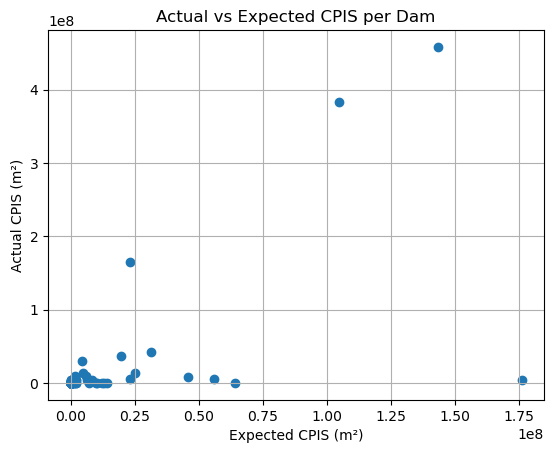


Per-country targeting ratios:
     actual_total  expected_total  targeting_ratio
ISO                                               
ZWE  5.146893e+06    3.757393e+05        13.698043
ZAF  1.226302e+09    8.028318e+08         1.527471
SEN  3.939440e+06    8.395258e+06         0.469246
SWZ  8.348418e+05    3.605767e+06         0.231530
NAM  2.066250e+06    1.008604e+07         0.204862
AGO  0.000000e+00    1.180344e+06         0.000000
NGA  0.000000e+00    7.553173e+02         0.000000
MLI  0.000000e+00    2.774353e+04         0.000000
MRT  0.000000e+00    2.686687e+05         0.000000
BFA  0.000000e+00    0.000000e+00              NaN
CMR  0.000000e+00    0.000000e+00              NaN
ETH  0.000000e+00    0.000000e+00              NaN
GHA  0.000000e+00    0.000000e+00              NaN
LSO  0.000000e+00    0.000000e+00              NaN
MOZ  0.000000e+00    0.000000e+00              NaN
SDN  0.000000e+00    0.000000e+00              NaN


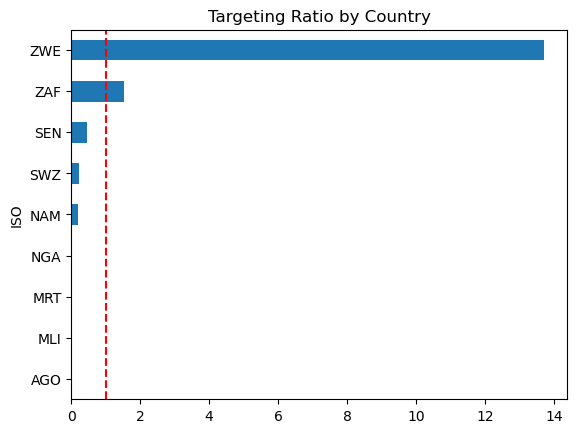


Zimbabwe (ZWE) details:
actual_total       5.146893e+06
expected_total     3.757393e+05
targeting_ratio    1.369804e+01
Name: ZWE, dtype: float64

Individual Zimbabwe dams:
        CPIS_in_CA  Expected_CPIS  Irr_in_CA  CPIS_country_area  \
GDW_ID                                                            
5295           0.0            0.0        0.0       6.459938e+08   
6656           0.0            0.0        0.0       6.459938e+08   
5308           0.0            0.0        0.0       6.459938e+08   
6663           0.0            0.0        0.0       6.459938e+08   
5309           0.0            0.0        0.0       6.459938e+08   
...            ...            ...        ...                ...   
2010           0.0            0.0        0.0       6.459938e+08   
5262           0.0            0.0        0.0       6.459938e+08   
6624           0.0            0.0        0.0       6.459938e+08   
6645           0.0            0.0        0.0       6.459938e+08   
7286           0.0    

In [11]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
cpis = gpd.read_file(resolve_path(config['SSA_Combined_CPIS_All_shp_path']))
dams = gpd.read_file(resolve_path(config['AridAfrica_Barriers_shp_path']))
dams.rename(columns={'COUNTRY': 'Country'}, inplace=True)
ca = gpd.read_file(resolve_path(config['No_Crop_Vectorized_Command_Area_shp_path']))
arid_ssa = gpd.read_file(resolve_path(config['SSA_Arid_by_Country_shp_path']))
irrig_raster_path = resolve_path(config['Africa_AEI_2000_asc_path'])

# Standardize CRS and ISO/Country column names
projected_crs = "EPSG:3857"
cpis = cpis.to_crs(projected_crs)
dams = dams.to_crs(projected_crs)

# Filter dams
print(f"Original number of dams: {len(dams)}")
dams['ISO'] = dams['Country'].map(country_to_iso)
dams = dams[dams['ISO'].isin(africa_iso_countries_SSA)]
dams = dams[(dams['DAM_HGT_M'] > 15) & (dams['MAIN_USE'] == 'Irrigation')]
print(f"Filtered dams count: {len(dams)}")

print("Data loaded and CRS matched")

# === Compute total CPIS area per country ===
cpis['area_m2'] = cpis.geometry.area
cpis.rename(columns={'ISO3': 'ISO'}, inplace=True)
national_cpis = cpis.groupby('ISO')['area_m2'].sum().rename("CPIS_country_area")
national_cpis = national_cpis[national_cpis.index.isin(africa_iso_countries_SSA)]

print("\nCountries with nonzero national CPIS area:")
print(national_cpis[national_cpis > 0])
print(f"Total countries with CPIS > 0: {sum(national_cpis > 0)}")
national_cpis[national_cpis > 0].sort_values().plot(kind='barh', title='National CPIS Areas')
plt.show()

# === Compute total irrigated area per country from raster ===
with rasterio.open(irrig_raster_path) as src:
    irrig_meta = src.meta.copy()
    irrig_data = src.read(1)
    irrig_transform = src.transform
    irrig_crs = "EPSG:4326"

if 'ISO' not in arid_ssa.columns:
    raise KeyError("The 'ISO' column is missing from the country boundaries shapefile.")

irrig_meta.update(dtype='int32', count=1)
arid_ssa = arid_ssa.to_crs(irrig_crs)
stats = zonal_stats(arid_ssa, irrig_raster_path, stats=["sum"], geojson_out=True)
irrig_by_country = {feature['properties']['ISO']: feature['properties']['sum'] for feature in stats}
national_irrig = pd.Series(irrig_by_country, name="Irr_country_area")
national_irrig = national_irrig[national_irrig.index.isin(africa_iso_countries_SSA)]
national_irrig *= 10_000

print("\nCountries with nonzero national irrigated area:")
print(national_irrig[national_irrig > 0])
print(f"Total countries with irrigated area > 0: {sum(national_irrig > 0)}")
national_irrig[national_irrig > 0].sort_values().plot(kind='barh', title='National Irrigated Areas')
plt.show()

# === CPIS within each command area ===
ca_proj = ca.to_crs(projected_crs)
cpis_ca = gpd.overlay(cpis, ca_proj, how='intersection')
cpis_ca['area_m2'] = cpis_ca.geometry.area
cpis_by_dam = cpis_ca.groupby('GDW_ID')['area_m2'].sum().rename("CPIS_in_CA")

print("\nTotal dams with CPIS detected in CA:")
print(f"Number of dams with CPIS > 0: {sum(cpis_by_dam > 0)} out of {len(cpis_by_dam)}")

# === Irrigated area within each command area ===
ca_zonal = ca.to_crs(irrig_crs)
ca_stats = zonal_stats(ca_zonal, irrig_raster_path, stats=["sum"], geojson_out=False)
ca['Irr_in_CA'] = [s["sum"] for s in ca_stats]
ca['Irr_in_CA'] = ca['Irr_in_CA'] * 10_000

print("\nTotal dams with irrigated area in CA:")
print(f"Number of dams with irrigation > 0: {sum(ca['Irr_in_CA'] > 0)} out of {len(ca)}")

# === Merge all sources together ===
print("Columns in ca:", ca.columns)
print("Columns in dams:", dams.columns)

ca_merge = ca.merge(dams[['GDW_ID', 'Country', 'ISO']], on='GDW_ID', how='left')
print("Columns in ca_merge:", ca_merge.columns)

ca_indexed = ca_merge.set_index('GDW_ID')
ca_indexed = ca_indexed.join(cpis_by_dam.rename("CPIS_in_CA")).fillna(0)
ca_indexed['CPIS_country_area'] = ca_indexed['ISO'].map(national_cpis)
ca_indexed['Irr_country_area'] = ca_indexed['ISO'].map(national_irrig)

# Avoid division by zero
ca_indexed = ca_indexed[ca_indexed['Irr_country_area'] > 0]

print("\nMerged dataset (first 5 rows):")
print(ca_indexed[['Country', 'CPIS_in_CA', 'Irr_in_CA', 'CPIS_country_area', 'Irr_country_area']].head())

print("\nSummary after merging:")
print(ca_indexed.describe())
print("\nCountries represented (count):")
print(ca_indexed['ISO'].value_counts())

# === Compute expected CPIS ===
ca_indexed['Expected_CPIS'] = ca_indexed['Irr_in_CA'] * (ca_indexed['CPIS_country_area'] / ca_indexed['Irr_country_area'])

print("\nExpected CPIS under national proportion model (first 5 rows):")
print(ca_indexed[['Expected_CPIS']].head())

plt.scatter(ca_indexed['Expected_CPIS'], ca_indexed['CPIS_in_CA'])
plt.xlabel('Expected CPIS (m²)')
plt.ylabel('Actual CPIS (m²)')
plt.title('Actual vs Expected CPIS per Dam')
plt.grid(True)
plt.show()

# === Compute targeting ratio ===
ca_indexed['Actual_minus_Expected'] = ca_indexed['CPIS_in_CA'] - ca_indexed['Expected_CPIS']

per_country = ca_indexed.groupby('ISO').agg(
    actual_total=('CPIS_in_CA', 'sum'),
    expected_total=('Expected_CPIS', 'sum')
)
per_country['targeting_ratio'] = per_country['actual_total'] / per_country['expected_total']
per_country = per_country.replace([np.inf, -np.inf], np.nan)

print("\nPer-country targeting ratios:")
print(per_country.sort_values('targeting_ratio', ascending=False))

per_country['targeting_ratio'].dropna().sort_values().plot(kind='barh', title='Targeting Ratio by Country')
plt.axvline(1.0, color='red', linestyle='--')
plt.show()

# === Specific investigation: Zimbabwe (ZWE) ===
if 'ZWE' in per_country.index:
    print("\nZimbabwe (ZWE) details:")
    print(per_country.loc['ZWE'])

    print("\nIndividual Zimbabwe dams:")
    print(ca_indexed[ca_indexed['ISO'] == 'ZWE'][['CPIS_in_CA', 'Expected_CPIS', 'Irr_in_CA', 'CPIS_country_area', 'Irr_country_area']])

# === Final targeting ratio for entire SSA region ===
total_actual = ca_indexed['CPIS_in_CA'].sum()
total_expected = ca_indexed['Expected_CPIS'].sum()
targeting_ratio = total_actual / total_expected if total_expected > 0 else np.nan

print("\nFinal Targeting Ratio:")
print(f"    Total Actual CPIS in CA: {total_actual:,.0f} m²")
print(f"    Total Expected CPIS:     {total_expected:,.0f} m²")
print(f"    Targeting Ratio:         {targeting_ratio:.3f}")